In [ ]:
#|default_exp data.transform

# Transform

> Utility function to transform features and target

In [ ]:
#hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#|export
#nbdev_comment from __future__ import annotations
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import savgol_filter
from fastcore.test import *

from mirzoo.data.loading import get_spectra, get_wetchem
from mirzoo.vis.core import plot_spectra

## Target variable

In [ ]:
#|export
def log_transform_y(data:tuple # (X, y, X_id, depth_order)
                   ):
    """
    Log-10 transform of the target value

    Takes and returns all (X, y, X_id, depth_order) tuple to be able to pipe the function
    """
    X, y, X_id, depth_order = data
    y = np.log10(y)
    return X, y, X_id, depth_order

## Features (spectra)

In [ ]:
#|export
CO2_REGION = [2389,  2269]

In [ ]:
#|export
class TakeDerivative(BaseEstimator, TransformerMixin):
    """Creates scikit-learn derivation custom transformer

    Args:
        window_length: int, optional
            Specify savgol filter smoothing window length

        polyorder: int, optional
            Specify order of the polynom used to interpolate derived signal

        deriv: int, optional
            Specify derivation degree

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self, window_length=11, polyorder=1, deriv=1):
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return savgol_filter(X, self.window_length, self.polyorder, self.deriv)

In [ ]:
fname = './files/RT_STD_allMIRspectra_raw.csv'
orgs, smp_ids, X_names, X, _ = get_spectra(fname)

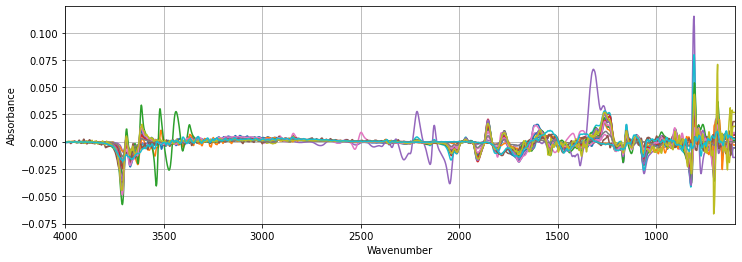

In [ ]:
tfm = TakeDerivative()
plot_spectra(tfm.fit_transform(X), X_names, figsize=(12,4))

In [ ]:
#|export
class SNV(BaseEstimator, TransformerMixin):
    """Creates scikit-learn SNV custom transformer

    Args:
        None

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        mean, std = np.mean(X, axis=1).reshape(-1, 1), np.std(X, axis=1).reshape(-1, 1)
        return (X - mean)/std

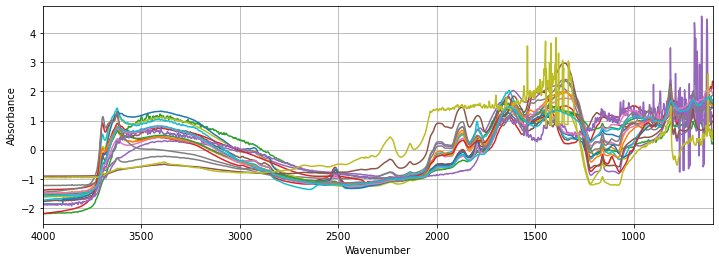

In [ ]:
tfm = SNV()
plot_spectra(tfm.fit_transform(X), X_names, figsize=(12,4))

In [ ]:
class Center(BaseEstimator, TransformerMixin):
    """Creates scikit-learn Centering custom transformer

    Args:
        None

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X - np.mean(X, axis=1).reshape(-1, 1)

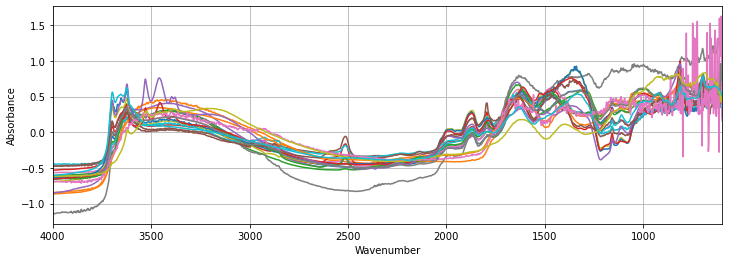

In [ ]:
tfm = Center()
plot_spectra(tfm.fit_transform(X), X_names, figsize=(12,4))

In [ ]:
#|export
class DropSpectralRegion(BaseEstimator, TransformerMixin):
    """Creates scikit-learn custom transformer dropping specific spectral region(s)

    Args:
        wavenumbers: list
            List of wavenumbers where absorbance measured

        region: list
            List of region(s) to drop

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self, wavenumbers, region=[2389,  2269]):
        self.wavenumbers = wavenumbers
        self.region = region

    def _closest_region(self, wavenumbers, region):
        #return [X_names[(np.abs(wavenumbers - w)).argmin()] for w in region]
        return [wavenumbers[(np.abs(wavenumbers - w)).argmin()] for w in region]

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = np.copy(X)
        high, low = self._closest_region(self.wavenumbers, self.region)
        mask = (self.wavenumbers <= high) & (self.wavenumbers >= low)
        X_transformed[:, mask] = 0
        return X_transformed

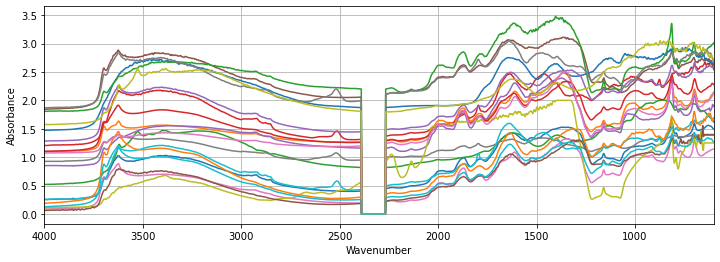

In [ ]:
tfm = DropSpectralRegion(X_names, region=CO2_REGION)
plot_spectra(tfm.fit_transform(X), X_names, figsize=(12,4))